In [1]:
import numpy as np
from gurobipy import *
import matplotlib.pyplot as plt
import time
import random
from TTHelperFuncts import *

In [2]:
# computeSiteAssignmentLSALP
   # this linear Program takes the cluster bounds and the matrix of distances that were already computed and generates
   # a linear program to minimize the the distance sums taking the cluster bounds into account
def computeSiteAssignmentLSALP(upperBound, lowerBound, distances):
    m = Model("assignment")
    m.Params.Method = 0
    m.Params.Presolve = 0
    m.Params.LogToConsole = 0
    #variables
    x = m.addVars(np.size(distances, axis = 0), np.size(distances, axis=1),lb = 0.0, ub = 1.0, name = "x") #vtype=GRB.BINARY, name="x")
    #objective
    m.setObjective(quicksum(x[i,j]*distances[i,j] for i in range(np.size(distances, axis = 0)) 
                                                                 for j in range(np.size(distances, axis=1))), GRB.MINIMIZE)
    #constraints
    for k in range(np.size(distances, axis = 0)):
        m.addConstr(quicksum(x[k, j] for j in range(np.size(distances, axis = 1))) <= upperBound[k])
        m.addConstr(quicksum(x[k, j] for j in range(np.size(distances, axis = 1))) >= lowerBound[k])
    for j in range(np.size(distances, axis = 1)):
        m.addConstr(quicksum(x[k, j] for k in range(np.size(distances, axis = 0))) == 1)    
    m.optimize()
    return m

# computeSiteAssignmentRadialLP
   # this linear Program takes the cluster bounds and the matrix of distances that were already computed and generates
   # a linear program to maximize the the distance sums taking the cluster bounds into account
def computeSiteAssignmentRadialLP(upperBound, lowerBound, distances):
    m = Model("assignmentRad")
    m.Params.Method = 0
    m.Params.Presolve = 0
    m.Params.LogToConsole = 0
    m.Params.IterationLimit = np.inf
    #variables
    x = m.addVars(np.size(distances, axis = 0), np.size(distances, axis=1),lb=0.0, ub=1.0, name="x")
    #objective
    m.setObjective(quicksum(x[i,j]*distances[i,j] for i in range(np.size(distances, axis = 0)) 
                                                                 for j in range(np.size(distances, axis=1))), GRB.MAXIMIZE)
    #constraints
    for k in range(np.size(distances, axis = 0)):
        m.addConstr(quicksum(x[k, j] for j in range(np.size(distances, axis = 1))) <= upperBound[k])
        m.addConstr(quicksum(x[k, j] for j in range(np.size(distances, axis = 1))) >= lowerBound[k])
    for j in range(np.size(distances, axis = 1)):
        m.addConstr(quicksum(x[k, j] for k in range(np.size(distances, axis = 0))) == 1)
    m.optimize()
    return m

# computeSiteAssignmentRadialLPSeeded
   # This LP specifies the start vector for the variables to perform a site assignment
def computeSiteAssignmentRadialLPSeeded(upperBound, lowerBound, distances, assignment):
    m = Model("assignment")
    m.Params.LogToConsole = 0
    #variables
    x = m.addVars(np.size(distances, axis = 0), np.size(distances, axis=1), lb=0.0,ub=1.0, name="x")
    #warm start
    for i in range(np.size(distances, axis = 0)):
        for j in range(np.size(distances, axis = 1)):
            x[i,j].start = assignment[np.size(distances,axis = 0)*i + j]
    #objective
    m.setObjective(quicksum(x[i,j]*distances[i,j] for i in range(np.size(distances, axis = 0)) 
                                                                 for j in range(np.size(distances, axis=1))), GRB.MAXIMIZE)
    #constraints
    for k in range(np.size(distances, axis = 0)):
        m.addConstr(quicksum(x[k, j] for j in range(np.size(distances, axis = 1))) <= upperBound[k])
        m.addConstr(quicksum(x[k, j] for j in range(np.size(distances, axis = 1))) >= lowerBound[k])
    for j in range(np.size(distances, axis = 1)):
        m.addConstr(quicksum(x[k, j] for k in range(np.size(distances, axis = 0))) == 1)
    
    m.optimize()
    return m

# computeRadialForBounds
   # This function updates the right hand side of the provided gurobi LP model and reoptimized
def computeRadialForBounds(k,n,upperLimBound, lowerLimBound, radDistance, cbasis, vbasis, model):
    model.Params.LogToConsole = 0
    #variables
    rhs = []
    for i in range(k):
        rhs.append(upperLimBound[i])
        rhs.append(lowerLimBound[i])
    for i in np.ones(n).tolist():
        rhs.append(i)
    model.setAttr("RHS",model.getConstrs(),rhs)
    model.update()
    #objective
    model.setAttr("cbasis",model.getConstrs(),cbasis)
    model.setAttr("vbasis",model.getVars(),vbasis)
    model.Params.IterationLimit = np.inf
    model.Params.Method = 0
    model.Params.Presolve = 0
    model.Params.Sifting = 0
    model.update()
    model.optimize()
    return model

*Cluster set up*

In [3]:
# setUpCluster
   # This function stores our collection of example problems that can be specified in the main executable code block
   # if you specify a test case that we do not have an error will be thrown. please set up any test case you wish to
   # to run in this function
def setUpCluster(sites, points, smallest, biggest, fixed=True):
    x = np.random.rand(points)
    y = np.random.rand(points)
    randPoints = []
    sitesStart = []
    sitesEnd = []
    if sites == 5 and points == 25:
        xStart = [
            (0.25, 0.75),
            (0.25, 0.25),
            (0.75, 0.25),
            (0.75, 0.75),
            (0.5, 0.5)
            ]
        xEnd = [
            (0.25, 0.55),
            (0.45, 0.25),
            (0.75, 0.45),
            (0.62, 0.62),
            (0.38, 0.63)
        ]
        for i in range(sites):
            #fixed path
            sitesStart.append((xStart[i][0]*float(points) , xStart[i][1]*float(points)))
            sitesEnd.append(((xEnd[i][0])*float(points) , (xEnd[i][1])*float(points)))
        randPoints = [(15.221633001844772, 6.781995878589397), (17.59595367040825, 13.147512333528406), (21.40778794346222, 18.331622802699787), (6.317821466992951, 20.234826634140237), (17.524645242032054, 10.348830525141182), (3.2591287562672044, 16.401816085263416), (15.914961843298011, 0.6931031165963525), (15.309868300284721, 5.9653441404959064), (22.872834811391474, 9.184055151913237), (3.067114275600566, 22.566677558415012), (13.917182029484247, 12.879449004887666), (8.785544914889407, 5.412707333920222), (19.23910810514951, 14.54705789921588), (2.2311704014433387, 10.160116756556647), (10.477880913938852, 18.850013191900317), (24.71436680326519, 2.32075199048066), (12.789282681144156, 23.668640169109935), (23.11759212118116, 7.463340546378452), (2.2293423001823713, 7.835738666901235), (18.258970734287967, 8.20332761291901), (4.469785378577765, 14.975895730133718), (3.573300609259453, 4.220005537238636), (20.995091841211945, 18.29864440912874), (12.406359416879853, 20.373198569196504), (14.294448731452523, 19.666348937624008)]
        uBound = np.array([5, 6, 5, 6, 5])
        lBound = np.array([5, 4, 4, 5, 5])
        startB = np.array([5, 4, 5, 6, 5])
        endB = np.array([5, 6, 4, 5, 5])
    elif sites == 5 and points == 50:
        xStart = [
            (0.25, 0.75),
            (0.25, 0.25),
            (0.75, 0.25),
            (0.75, 0.75),
            (0.5, 0.5)
            ]
        xEnd = [
            (0.25, 0.55),
            (0.45, 0.25),
            (0.75, 0.45),
            (0.62, 0.62),
            (0.38, 0.63)
        ]
        for i in range(sites):
            #fixed path
            sitesStart.append((xStart[i][0]*float(points) , xStart[i][1]*float(points)))
            sitesEnd.append(((xEnd[i][0])*float(points) , (xEnd[i][1])*float(points)))
            
        randPoints = [(31.16113984517791, 21.166563868714007), (14.63307911286188, 25.094072975077967), (40.40936122158677, 5.346273922359473), (23.211737947126167, 27.55254721715336), (20.06769877971345, 47.06311026756072), (45.29883078425508, 31.458780439098405), (29.76258512421341, 11.166090581012527), (8.907678193368817, 13.031160194325537), (42.162343729180535, 2.7463795370004043), (24.55966379173187, 3.832229137865001), (8.682350734081695, 41.23697074015028), (27.255371570878783, 2.9894060656837587), (4.523551601868098, 37.77344747446164), (32.52800870362614, 47.08157538656199), (40.58695806590713, 36.0326981146497), (8.010437645081236, 8.960111084449146), (45.42611606107262, 4.765827790085203), (34.45704719365779, 24.778929049870417), (18.255190828746986, 31.428115969331245), (49.17541184347085, 17.89405520841149), (21.691667727230378, 44.14187468796354), (40.09091393891083, 31.195501549727776), (9.951933901383498, 12.80510589443644), (12.8612335141214, 15.301358108229513), (49.446374302958276, 47.5742365957286), (11.788159529907432, 11.37182303415074), (18.713377220106942, 10.958908144846141), (10.899570588236212, 11.33259852809822), (3.986084448881766, 6.8997992978783005), (2.1277239516725386, 20.374779239156837), (9.85917784332645, 36.636598831256926), (29.89399754349175, 46.5915588456148), (10.673743743764602, 19.043978563898495), (25.140014267090006, 17.133911540806913), (13.8656358045525, 24.542981597901946), (34.32976500250821, 44.114651127944164), (41.217200272085655, 39.57909252016687), (42.8239677951138, 3.1995169292322156), (13.882557466881801, 44.273418071331264), (10.042159661914745, 44.15583726861023), (33.08721831115417, 25.72467627132662), (31.977744325505647, 31.886303106397772), (20.282018616215858, 40.73177583305025), (42.00597951395657, 25.59552860574416), (23.31296823710713, 23.757618400790186), (42.68418862153103, 27.43245142750678), (16.163871003272977, 41.2756708115393), (45.23457626004472, 41.19275546677188), (34.95644925182627, 42.75783464330073), (23.545715233486952, 29.05540484626919)]
        uBound = np.array([10, 11, 11, 11, 11])
        lBound = np.array([ 9, 10,  9, 10,  8])
        startB = np.array([ 9, 10,  9, 11, 11])
        endB = np.array([10, 11, 11, 10,  8])
    else:
        raise ValueError("Please specify a preset site and datapoint combination")
    
    return sitesStart, sitesEnd, randPoints, uBound, lBound, startB, endB

# startingClusters
   # This function takes the test case that was specified and generates all the other data that is needed 
   # to begin computing the transition
def startingClusters(sStart, sEnd, points, upper, lower, start, end):
    #starting LSA assignment
    lsaDistance = nonWeightedDistanceLSA(sStart, points)
    lsaAssignment = computeSiteAssignmentLSALP(start, start, lsaDistance)
    x = lsaAssignment.x
    lsaStartVect = x
    lsaStart = genCurPointAssign(x, len(sStart), len(points))
    #starting Radial assignment
    radDistance = nonWeightedDistanceRadial(sStart, points)
    radAssignment = computeSiteAssignmentRadialLP(upper, lower, radDistance)
    x = radAssignment.x
    radStart = genCurPointAssign(x, len(sStart), len(points))
    #ending LSA assignment
    lsaDistance = nonWeightedDistanceLSA(sEnd, points)
    lsaAssignment = computeSiteAssignmentLSALP(end, end, lsaDistance)
    x = lsaAssignment.x
    lsaEndVect = x
    testlsaEnd = np.zeros(len(points))
    lsaEnd = genCurPointAssign(x, len(sStart), len(points))

    #ending Radial assignment
    radDistance = nonWeightedDistanceRadial(sEnd, points)
    radAssignment = computeSiteAssignmentRadialLP(upper, lower, radDistance)
    x = radAssignment.x
    radEnd = genCurPointAssign(x, len(sStart), len(points))
    return lsaStart, radStart, lsaStartVect, lsaEnd, radEnd, lsaEndVect


### Fixed LSA2 Radial ###

In [4]:
# modelSeed
   # This function precomputes the basis vectors we need from gurobi to use warm start methods
def modelSeed(sites, points, upper, lower, lsaBound):
    #starting LSA assignment
    lsaDistance = nonWeightedDistanceLSA(sites, points)
    lsaAssignment = computeSiteAssignmentLSALP(lsaBound, lsaBound, lsaDistance)
    lsaCBasis = lsaAssignment.cbasis
    lsaVBasis = lsaAssignment.vbasis
            
    #starting Radial assignment
    radDistance = nonWeightedDistanceRadial(sites, points)
    radAssignment = computeSiteAssignmentRadialLP(upper, lower, radDistance)
    
    return lsaCBasis, lsaVBasis, radAssignment.cbasis, radAssignment.vbasis

# LSA2RadialNew
   # Algorithm 2 in the paper
def LSA2RadialNew(k,n,sites, points, lsaAssign, upper, lower, model, radAssign, lsaModel,radDistance):
    # begin with current assignment and cluster sizes
    curAssign = np.copy(lsaAssign)
    currentAssignCount = np.zeros(k)
    for i in range(n):
        currentAssignCount[int(curAssign[i])] += 1.
    printCurrentAssignment(curAssign, points, sites)
    #test if we are already done
    if sameAssignment(lsaAssign, radAssign):
        return 0,0, True
    
    # counting time
    timeSum = 0
    iterCount = 0
    count = 0
    start = time.time()
    previousObjectiveValue = lsaModel.getObjective().getValue()
    cbasis = lsaModel.cbasis
    vbasis = lsaModel.vbasis
    finalObjectiveValue = model.getObjective().getValue()

    model.reset()
    while previousObjectiveValue < finalObjectiveValue:
        count += 1 
        oldAssignCount = np.copy(currentAssignCount)
        oldAssign = np.copy(curAssign)
        
        changeOptions = getAllPairsOfClusters(k,oldAssignCount,lower,upper)

        alreadytried = []
        while True:
            choice = random.choice(changeOptions)
            
            upperLimBound, lowerLimBound = genLimitedBounds(choice, oldAssignCount)
            model = computeRadialForBounds(k,n,upperLimBound, lowerLimBound, radDistance, cbasis, vbasis, model)
            currentObjectiveValue = model.getObjective().getValue()
            if previousObjectiveValue < currentObjectiveValue:
                x = model.x
                for i in range(k):
                    for j in range(n):
                        if x[n*i + j] == 1.0:
                            curAssign[j] = i
                printCurrentAssignment(curAssign, points, sites)
                currentAssignCount = np.zeros(k)
                for i in range(n):
                    currentAssignCount[int(curAssign[i])] += 1
                break      
        previousObjectiveValue = np.copy(currentObjectiveValue)
        cbasis = model.cbasis
        vbasis = model.vbasis
        if count == 1:
            comparisoncounter = 0
            for i in range(len(curAssign)):
                if not oldAssign[i] == curAssign[i]:
                    comparisoncounter += 1
            if comparisoncounter == 1:
                count -=1       
        previousX = np.copy(model.x)
    timeSum += time.time() - start    
    iterCount+= count
    return iterCount, timeSum, True    


### LSA to Radial function ###

In [5]:
def LSA2Radial(k,n,sites, points, upperBounds, lowerBounds, lsaBound, lsaAssign, radAssign):
    sLSAcBasis, sLSAvBasis, sRadcBasis, sRadvBasis = modelSeed(end, points, upperBounds, lowerBounds, lsaBound)

    lsaDistance = nonWeightedDistanceLSA(sites, points)
    lsaModel = computeSiteAssignmentLSALP(lsaBound, lsaBound, lsaDistance)
    radDistance = nonWeightedDistanceRadial(sites, points)
    radModel = computeSiteAssignmentRadialLP(upperBounds, lowerBounds, radDistance)
    iterCount, startTime, usable = LSA2RadialNew(k,n,sites, points, lsaAssign,
                                                upperBounds, lowerBounds, radModel, radAssign, lsaModel,radDistance)
    return iterCount, startTime, time.time(), usable

### Radial to Radial Step ###

In [6]:
# computeLambda
   # This function finds the next lambda value as described in the paper for the next time a shift could occur
def computeLambda(upperBound, lowerBound, k,n, primalObjFun, primalObjFunValue, DeltaObjFun, primalSolution):
    m = Model("breakRad")
    m.Params.Method = 0
    m.Params.Presolve = 0
    m.Params.LogToConsole = 0
    m.Params.IterationLimit = np.inf
    
    #variables
    y1 = m.addVars(n, lb = -GRB.INFINITY, ub=GRB.INFINITY, vtype=GRB.CONTINUOUS, name="y1") # each item assigned
    y2 = m.addVars(k, lb = -GRB.INFINITY, ub=0.0, vtype=GRB.CONTINUOUS, name="y2") #lower bounds
    y3 = m.addVars(k, lb=0.0, ub=GRB.INFINITY, vtype=GRB.CONTINUOUS, name="y3") # upper bounds

    breakpoint = m.addVar(lb=0.0, ub=GRB.INFINITY, vtype=GRB.CONTINUOUS, name = "breakpoint") # the breakpoint
    
    #objective
    m.setObjective(breakpoint, GRB.MAXIMIZE)
    #constraints
    for i in range(k):
        for j in range(n):
            m.addConstr(y1[j]+y2[i]+y3[i] - DeltaObjFun[i,j]*breakpoint >= primalObjFun[i,j])
    m.addConstr(quicksum(y1[i] for i in range(n))+quicksum(y2[i]*lowerBound[i] for i in range(k))+quicksum(y3[i]*upperBound[i] for i in range(k))
                     -breakpoint*quicksum(DeltaObjFun[i,j]*primalSolution[i*n+j] for i in range(k) for j in range(n))
                    ==primalObjFunValue )
    
    m.optimize()
    return m

# computeLambdaReuse
   # Once the model exists it is computationally faster to reuse it. This function modifies the model as  
   # necessary
def computeLambdaReuse(model, k,n, primalObjFun, primalObjFunValue, DeltaObjFun, primalSolution):
    constraints = model.getConstrs()
    breakpoint = model.getVarByName("breakpoint") 
    quickSumTerm = 0.0
    #constraints
    for i in range(k):
        for j in range(n):
            model.chgCoeff(constraints[i*n+j], breakpoint, (-1)*DeltaObjFun[i,j])
            constraints[i*n+j].setAttr("RHS",primalObjFun[i,j])
            quickSumTerm += DeltaObjFun[i,j]*primalSolution[i*n+j]
            #rhs.append(primalObjFun[i,j])
    model.chgCoeff(constraints[k*n], breakpoint, (-1)*quickSumTerm)
    constraints[k*n].setAttr("RHS",primalObjFunValue)
    model.optimize()
    return model

# Radial2Radial
   # Algorithm 3 in the paper
def Radial2Radial(start, end, points, upperBounds, lowerBounds, step):
    startTime = time.time()
    iterCount = 0.0
    timeCount = 0.0
    #compute starting distance and start = current
    radCurrentDistance = nonWeightedDistanceRadial(start, points)
    radCurrentModel = computeSiteAssignmentRadialLP(upperBounds, lowerBounds, radCurrentDistance)

    #compute ending distance and radial clustering
    radEndDistance = nonWeightedDistanceRadial(end, points)
    radEndModel = computeSiteAssignmentRadialLP(upperBounds, lowerBounds, radEndDistance)

    #this stays fixed. current still is the same as start
    DeltaDistance = radEndDistance - radCurrentDistance

    counter = 0
    totallambda = 0

    while(True):
        counter = counter + 1
        continueValue = False
               
        # compute the primal objective function value and get the current solution
        obj = radCurrentModel.getObjective()
        primalObjValue = obj.getValue()
        primalSolutionVector = radCurrentModel.x
    
        # find next lambda. (called newBreak)
        if counter <=1 :
            lambdaCurrentModel=computeLambda(upperBounds, lowerBounds, k,n, radCurrentDistance, primalObjValue, DeltaDistance, primalSolutionVector)
        else:
            lambdaCurrentModel =computeLambdaReuse(lambdaCurrentModel,k,n, radCurrentDistance, primalObjValue, DeltaDistance, primalSolutionVector)
        iterCount += lambdaCurrentModel.IterCount
        timeCount += lambdaCurrentModel.Runtime
        newBreak = lambdaCurrentModel.getVarByName('breakpoint').X

        # update distances
        newDistance = radCurrentDistance + (step*newBreak)*DeltaDistance
  
        totallambda = totallambda + (1-totallambda)*step*newBreak
    
        radCurrentDistance = newDistance
        DeltaDistance = radEndDistance - radCurrentDistance
    
        # compute new clustering with arm start
        radNextModel = computeSiteAssignmentRadialLPSeeded(upperBounds, lowerBounds, radCurrentDistance,primalSolutionVector)
    
        test = 0
        DiffBetween=np.zeros((k, n))
        for i in range(k):
            for j in range(n):
                DiffBetween[i,j]=radCurrentModel.x[i*n+j]-radNextModel.x[i*n+j]
                if(DiffBetween[i,j] != 0.0):
                    test += 1
        if(test == 0):
            
            break
        if(totallambda > 1):
            break
        radCurrentModel = radNextModel
        curAssign = np.zeros(n)
        x = radNextModel.x
        for i in range(k):
            for j in range(n):
                if x[n*i + j] == 1.0:
                    curAssign[j] = i
        tempSites = getCurrentSites(start, end, totallambda)
        printCurrentAssignment(curAssign, points, tempSites)
    totalTime = time.time() - startTime 
    return counter, totalTime, (iterCount/float(counter)),(timeCount/float(counter))


--------------------------------------------
--------------------------------------------

Using license file C:\Users\stets\gurobi.lic
Academic license - for non-commercial use only
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter Presolve to 0
   Prev: -1  Min: -1  Max: 2  Default: -1
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter Presolve to 0
   Prev: -1  Min: -1  Max: 2  Default: -1
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter Presolve to 0
   Prev: -1  Min: -1  Max: 2  Default: -1
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter Presolve to 0
   Prev: -1  Min: -1  Max: 2  Default: -1
the number of points that change are  12
Step1 LSA to Radial Start
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed valu

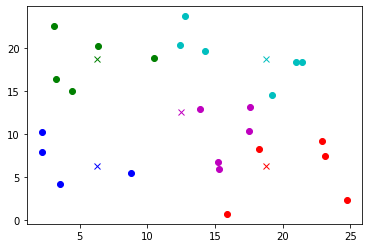

Step2 LSA to Radial End
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter Presolve to 0
   Prev: -1  Min: -1  Max: 2  Default: -1
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter Presolve to 0
   Prev: -1  Min: -1  Max: 2  Default: -1
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter Presolve to 0
   Prev: -1  Min: -1  Max: 2  Default: -1
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter Presolve to 0
   Prev: -1  Min: -1  Max: 2  Default: -1


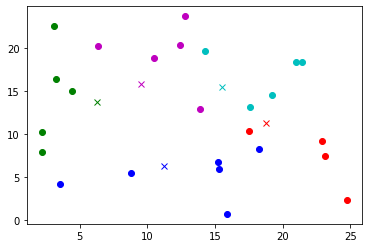

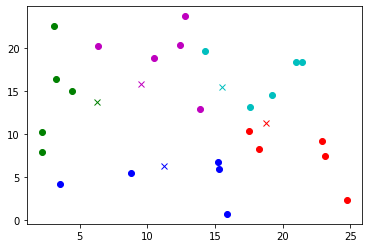

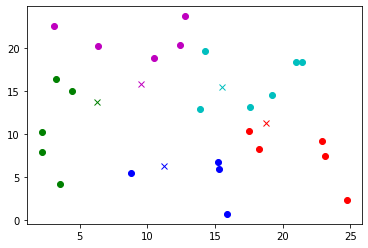

Step3 Radial to Radial
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter Presolve to 0
   Prev: -1  Min: -1  Max: 2  Default: -1
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter Presolve to 0
   Prev: -1  Min: -1  Max: 2  Default: -1
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter Presolve to 0
   Prev: -1  Min: -1  Max: 2  Default: -1


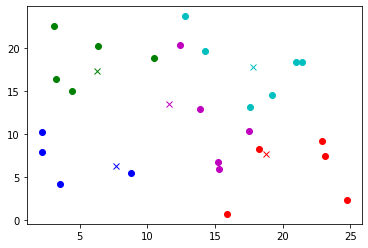

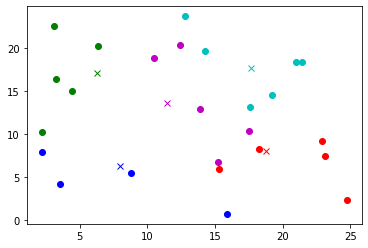

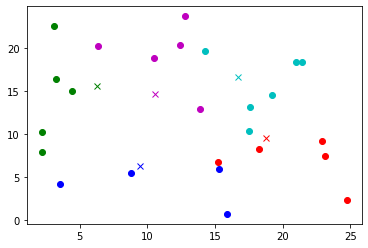

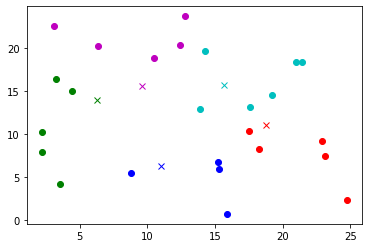

time to compute LRStart
0
steps computing LRStart
0
time to compute LREnd
0.3165600299835205
steps computing LREnd
1
RR run time
0.6548759937286377
steps computing RR breakpoints
5


In [7]:
# please do not change this value.
k = 5

#this value can be either 25 or 50 when k = 5 
n = 25

# if n = 25 set this to 3 and 7. if n= 50 use 8 and 12.
small = 8
big = 12

#these are just setting up the run information
epsilon = 1.05
timeSumRR = 0
stepSumRR = 0
timeSumLRStart = 0
stepSumLRStart = 0
timeSumRLEnd = 0
stepSumRLEnd = 0
sliceSteps = 0
diffCount = 0

start, end, points, upperBounds, lowerBounds, startBound, endBound = setUpCluster( k, n, small, big)

sAssignmentLSA, sAssignmentRad, sAssignmentVect, eAssignmentLSA, eAssignmentRad, eAssignmentVect = startingClusters(start, end, points, upperBounds, 
                                                                                     lowerBounds, startBound, endBound)

print("the number of points that change are  " + str(diffCounter(sAssignmentLSA, eAssignmentLSA)))
diffCount += diffCounter(sAssignmentLSA, eAssignmentLSA)
print("Step1 LSA to Radial Start")
IterCountStart, LSAStartTime, LSAStartEndTime, usable = LSA2Radial(k,n,start, points, upperBounds, lowerBounds, startBound, sAssignmentLSA, sAssignmentRad)


timeSumLRStart += LSAStartTime
stepSumLRStart += IterCountStart
print("Step2 LSA to Radial End")
IterCountEnd, LSAEndTime, LSAEndEndTime, usable = LSA2Radial(k,n,end, points, upperBounds, lowerBounds, endBound, eAssignmentLSA, eAssignmentRad)
print("Step3 Radial to Radial")
stepCountRadial, totalTimeRRStep, avgRRIters, avgRRRunTime = Radial2Radial(start, end, points, upperBounds,
                                 lowerBounds,epsilon)
timeSumRR += totalTimeRRStep
stepSumRR += stepCountRadial
timeSumLRStart += LSAStartTime
stepSumLRStart += IterCountStart
timeSumRLEnd += LSAEndTime
stepSumRLEnd += IterCountEnd


print("time to compute LRStart")
print(timeSumLRStart)
print("steps computing LRStart")
print(stepSumLRStart)
print("time to compute LREnd")
print(timeSumRLEnd)
print("steps computing LREnd")
print(stepSumRLEnd)
print("RR run time")
print(timeSumRR)
print("steps computing RR breakpoints")
print(stepSumRR)